# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Load dataset

In [ ]:
!kaggle datasets download -d rohith203/traffic-volume-dataset

Dataset URL: https://www.kaggle.com/datasets/rohith203/traffic-volume-dataset
License(s): unknown
  0% 0.00/719k [00:00<?, ?B/s]
100% 719k/719k [00:00<00:00, 70.2MB/s]


In [ ]:
!unzip traffic-volume-dataset.zip

Archive:  traffic-volume-dataset.zip
  inflating: Test.csv                
  inflating: Train.csv               
  inflating: sample_submission.csv   


In [ ]:
df = pd.read_csv('Train.csv')
df.head()

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
0,2012-10-02 09:00:00,NaN,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
1,2012-10-02 10:00:00,NaN,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2,2012-10-02 11:00:00,NaN,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
3,2012-10-02 12:00:00,NaN,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
4,2012-10-02 13:00:00,NaN,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918


# EDA & Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            33750 non-null  object 
 1   is_holiday           43 non-null     object 
 2   air_pollution_index  33750 non-null  int64  
 3   humidity             33750 non-null  int64  
 4   wind_speed           33750 non-null  int64  
 5   wind_direction       33750 non-null  int64  
 6   visibility_in_miles  33750 non-null  int64  
 7   dew_point            33750 non-null  int64  
 8   temperature          33750 non-null  float64
 9   rain_p_h             33750 non-null  float64
 10  snow_p_h             33750 non-null  float64
 11  clouds_all           33750 non-null  int64  
 12  weather_type         33750 non-null  object 
 13  weather_description  33750 non-null  object 
 14  traffic_volume       33750 non-null  int64  
dtypes: float64(3), int64(8), object(4)
m

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
air_pollution_index,33750.0,154.841422,83.735515,10.0,83.00,155.00,228.00,299.00
humidity,33750.0,71.209007,16.852248,13.0,60.00,72.00,85.00,100.00
wind_speed,33750.0,3.378193,2.055792,0.0,2.00,3.00,5.00,16.00
wind_direction,33750.0,199.471852,99.841088,0.0,130.00,200.00,290.00,360.00
visibility_in_miles,33750.0,4.989748,2.570021,1.0,3.00,5.00,7.00,9.00
dew_point,33750.0,4.989748,2.570021,1.0,3.00,5.00,7.00,9.00
temperature,33750.0,280.069587,13.415256,0.0,271.72,280.15,290.62,308.24
rain_p_h,33750.0,0.448739,53.526500,0.0,0.00,0.00,0.00,9831.30
snow_p_h,33750.0,0.000318,0.009760,0.0,0.00,0.00,0.00,0.51
clouds_all,33750.0,50.458785,38.871734,0.0,1.00,64.00,90.00,100.00


In [ ]:
df.isna().sum()

,0
date_time,0
is_holiday,33707
air_pollution_index,0
humidity,0
wind_speed,0
wind_direction,0
visibility_in_miles,0
dew_point,0
temperature,0
rain_p_h,0


In [ ]:
df.isna().mean()*100

,0
date_time,0.000000
is_holiday,99.872593
air_pollution_index,0.000000
humidity,0.000000
wind_speed,0.000000
wind_direction,0.000000
visibility_in_miles,0.000000
dew_point,0.000000
temperature,0.000000
rain_p_h,0.000000


In [ ]:
df.duplicated().sum()

0

In [ ]:
df=df.drop('is_holiday', axis=1) #Drop this column because the percentage of missing values is 99%

In [ ]:
# Feature extraction from date_time
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_time            33750 non-null  datetime64[ns]
 1   air_pollution_index  33750 non-null  int64         
 2   humidity             33750 non-null  int64         
 3   wind_speed           33750 non-null  int64         
 4   wind_direction       33750 non-null  int64         
 5   visibility_in_miles  33750 non-null  int64         
 6   dew_point            33750 non-null  int64         
 7   temperature          33750 non-null  float64       
 8   rain_p_h             33750 non-null  float64       
 9   snow_p_h             33750 non-null  float64       
 10  clouds_all           33750 non-null  int64         
 11  weather_type         33750 non-null  object        
 12  weather_description  33750 non-null  object        
 13  traffic_volume       33750 non-

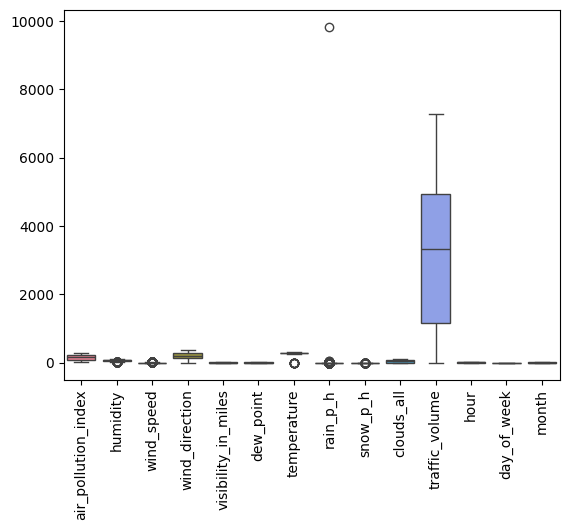

In [ ]:
sns.boxplot(df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Function for remove outliers

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers(df, 'rain_p_h')
df = remove_outliers(df, 'temperature')


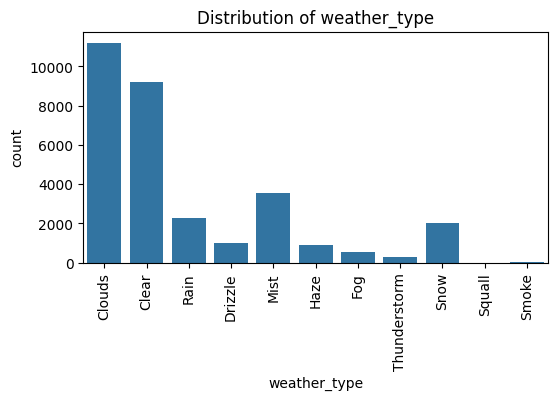

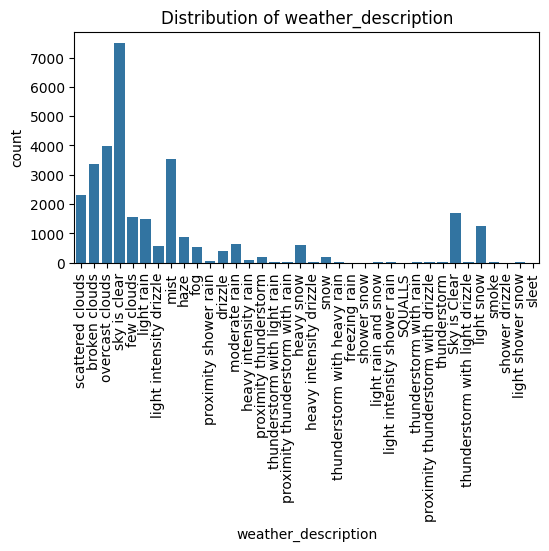

In [ ]:
# plot the distribution of categorical features
categorical_features = ['weather_type', 'weather_description']

for feature in categorical_features:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=df[feature])
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
features = df[['traffic_volume', 'temperature']]

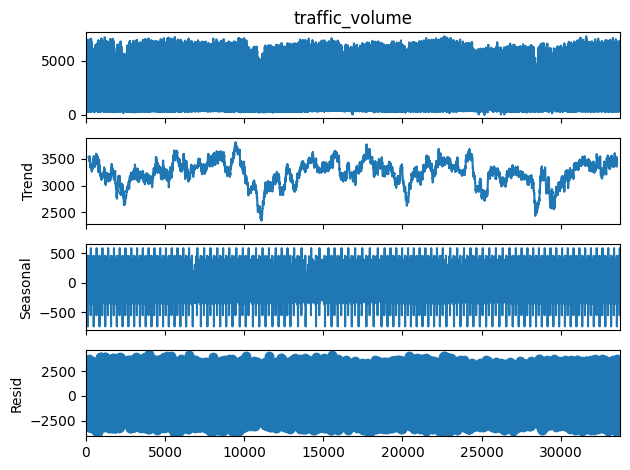

In [ ]:
#Apply ETS
result = seasonal_decompose(df['traffic_volume'], model='additive', period=365)

#plot ETS
result.plot()
plt.show()

In [ ]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
# Create a DataFrame from the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=['traffic_volume', 'temperature'])

# Data splitting

In [ ]:
def create_sequences(data, time_steps=10):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        Y.append(data[i + time_steps, 0])  # Predicting 'traffic_volume'
    return np.array(X), np.array(Y)
time_steps = 10
X, Y = create_sequences(scaled_df.values, time_steps)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# LSTM Model

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(time_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for predicting traffic_volume

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/50
775/775 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.0398 - val_loss: 0.0109
Epoch 2/50
775/775 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0130 - val_loss: 0.0103
Epoch 3/50
775/775 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - loss: 0.0121 - val_loss: 0.0101
Epoch 4/50
775/775 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 5/50
775/775 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0103 - val_loss: 0.0091
Epoch 6/50
775/775 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0098 - val_loss: 0.0086
Epoch 7/50
775/775 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0094 - val_loss: 0.0081
Epoch 8/50
775/775 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0091 - val_loss: 0.0080
Epoch 9/50
775/775 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 10/50
775/775 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 11/50
775/775 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 12/50
775/775 ━━━━━━━━━━

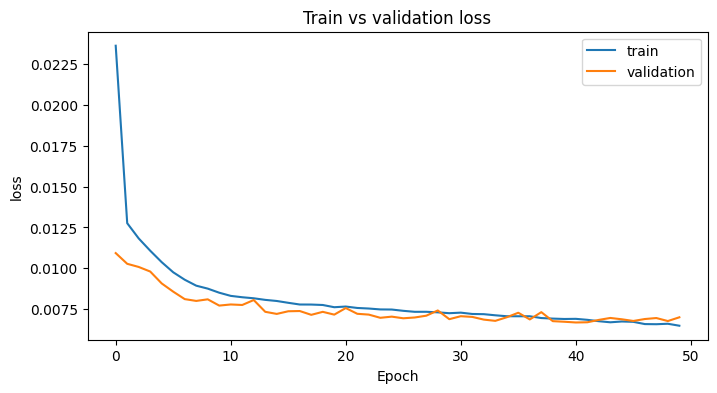

In [ ]:
    # Plot the loss result of training and validation
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [ ]:
# Evaluate the model using test data
result=model.evaluate(X_test,Y_test)
result

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0071


0.006994788534939289

775/775 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


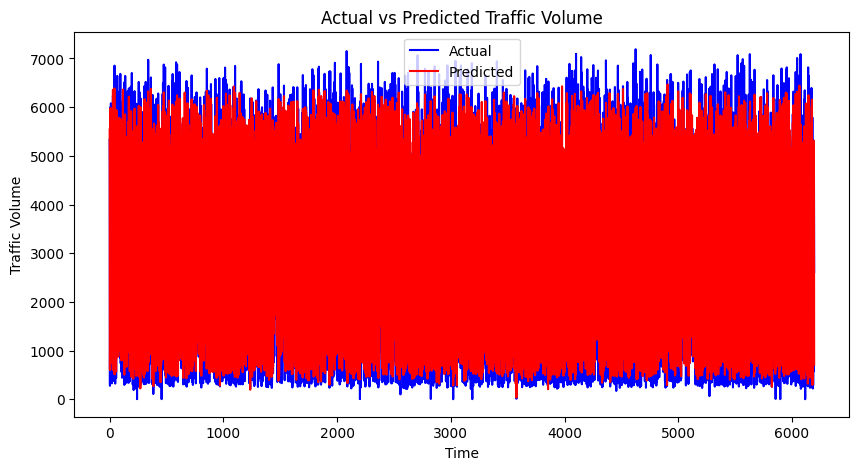

In [ ]:
# Predicting
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Ensure predictions have the correct number of features
trainPredict = trainPredict.reshape(-1, 1)
testPredict1 = testPredict.reshape(-1, 1)

# Inverse transform the predictions
trainPredict = scaler.inverse_transform(np.concatenate((trainPredict, np.zeros((trainPredict.shape[0], 1))), axis=1))[:,0]
testPredict1 = scaler.inverse_transform(np.concatenate((testPredict1, np.zeros((testPredict1.shape[0], 1))), axis=1))[:,0]

# Inverse transform the actual values
trainY = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], 1))), axis=1))[:,0]
testY = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], 1))), axis=1))[:,0]

# Plot the results of Actual and Predicted values
plt.figure(figsize=(10, 5))
plt.plot(testY, label='Actual', color='blue')
plt.plot(testPredict1, label='Predicted', color='red')
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()
